In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

## define helper functions

In [2]:
# define a function to gather positions
def get_pos(n_x, n_y):
    # create the hex lattice
    xs = np.array([np.arange(0, n_x) + 0.5 if idx % 2 == 0 else np.arange(0, n_x) for idx in range(n_y)])
    # derive the y-step given a distance of one
    y_step = np.sqrt(1**2+0.5**2)
    ys = np.array([[y_step * idy] * n_x for idy in range(n_y)])
    # define the positions
    pos = np.vstack([xs.flatten(), ys.flatten()]).T
    return pos

In [3]:
# define a function to derive the gex from the sphex
def calc_gex(sphex):
    """
    Calculates the gene expression matrix from the spherical
    """
    # setup the gex
    n_genes = sphex.shape[1]+1
    gex = torch.from_numpy(np.zeros((sphex.shape[0], n_genes)).astype('float32'))
    # compute the gex
    for idx in range(n_genes):
        if idx == n_genes-1:
            gex[:,idx] = torch.sin(sphex[:,idx-1])
        else:
            gex[:,idx] = torch.cos(sphex[:,idx])
        for idx_ in range(idx):
            gex[:,idx] *= torch.sin(sphex[:,idx_])
    return gex

In [4]:
from torch_geometric.nn import GCNConv
from sklearn.neighbors import kneighbors_graph
# define the number of neighbors (six for visium)
n_neighbors = 6
# define the simcomen class
class simcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(simcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.sphex = None
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_sphex(self, sphex):
        """
        Artifically sets the current sphex matrix
        """
        self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the gex
        self.gex = calc_gex(self.sphex)
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [5]:
# define the celcomen class
class celcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(celcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=True)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g)).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=True)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_gex(self, gex):
        """
        Artifically sets the current sphex matrix
        """
        self.gex = torch.nn.Parameter(gex, requires_grad=False)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [6]:
# define a function to normalize the g2g
def normalize_g2g(g2g):
    """
    Addresses any small fluctuations in symmetrical weights
    """
    # symmetrize the values
    g2g = (g2g + g2g.T) / 2
    # force them to be between 0-1
    g2g[g2g < 0] = 0
    g2g[g2g > 1] = 1
    # force the central line to be 1
    for idx in range(len(g2g)):
        g2g[idx, idx] = 1
    return g2g

## read in xenium

In [8]:
# read in xenium
avis = sc.read_10x_h5('data/xenium_human_gbm/cell_feature_matrix.h5')
avis.var_names = avis.var_names.astype(str)
avis.var_names_make_unique()
# remove cells with no counts
sc.pp.filter_cells(avis, min_counts=100)
# normalize the data
sc.pp.normalize_total(avis, target_sum=1e6)
sc.pp.log1p(avis)

In [9]:
# read in the spatial
df = pd.read_csv('data/xenium_human_gbm/cells.csv.gz', index_col=0)
df = df.loc[avis.obs.index]

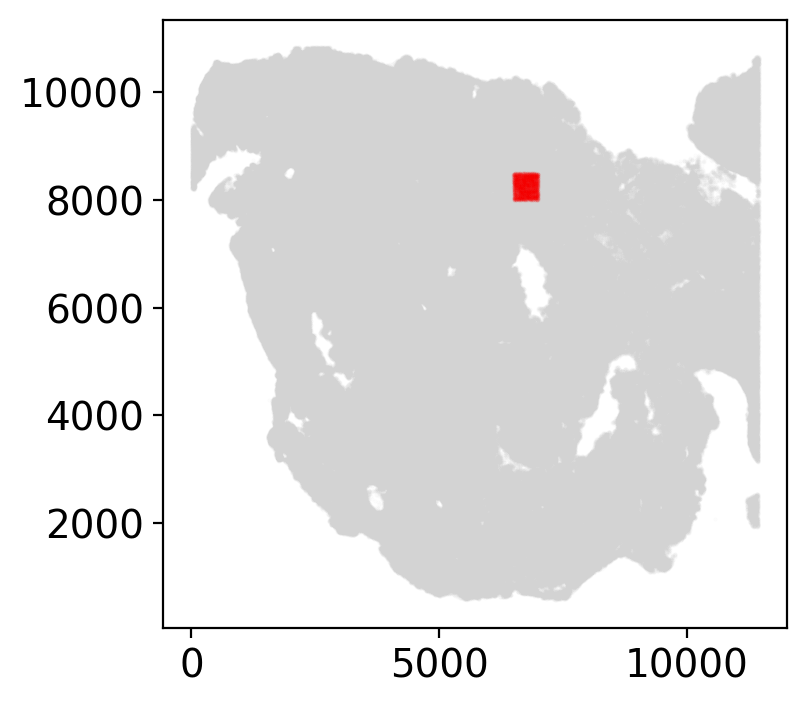

In [10]:
# view the tissue and choose a specific area to focus on
fig, ax = plt.subplots()
ax.grid(False)
ax.scatter(df['x_centroid'], df['y_centroid'], s=0.1, alpha=0.1, color='lightgray')
mask = (df['x_centroid'] < 7000) & (df['x_centroid'] > 6500)
mask = mask & (df['y_centroid'] < 8500) & (df['y_centroid'] > 8000)
ax.scatter(df.loc[mask, 'x_centroid'], df.loc[mask, 'y_centroid'], s=0.1, alpha=0.1, color='r')

In [11]:
# add spatial and subset
avis.obsm['spatial'] = df.loc[avis.obs.index, ['x_centroid','y_centroid']].values
avis = avis[mask].copy()

/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


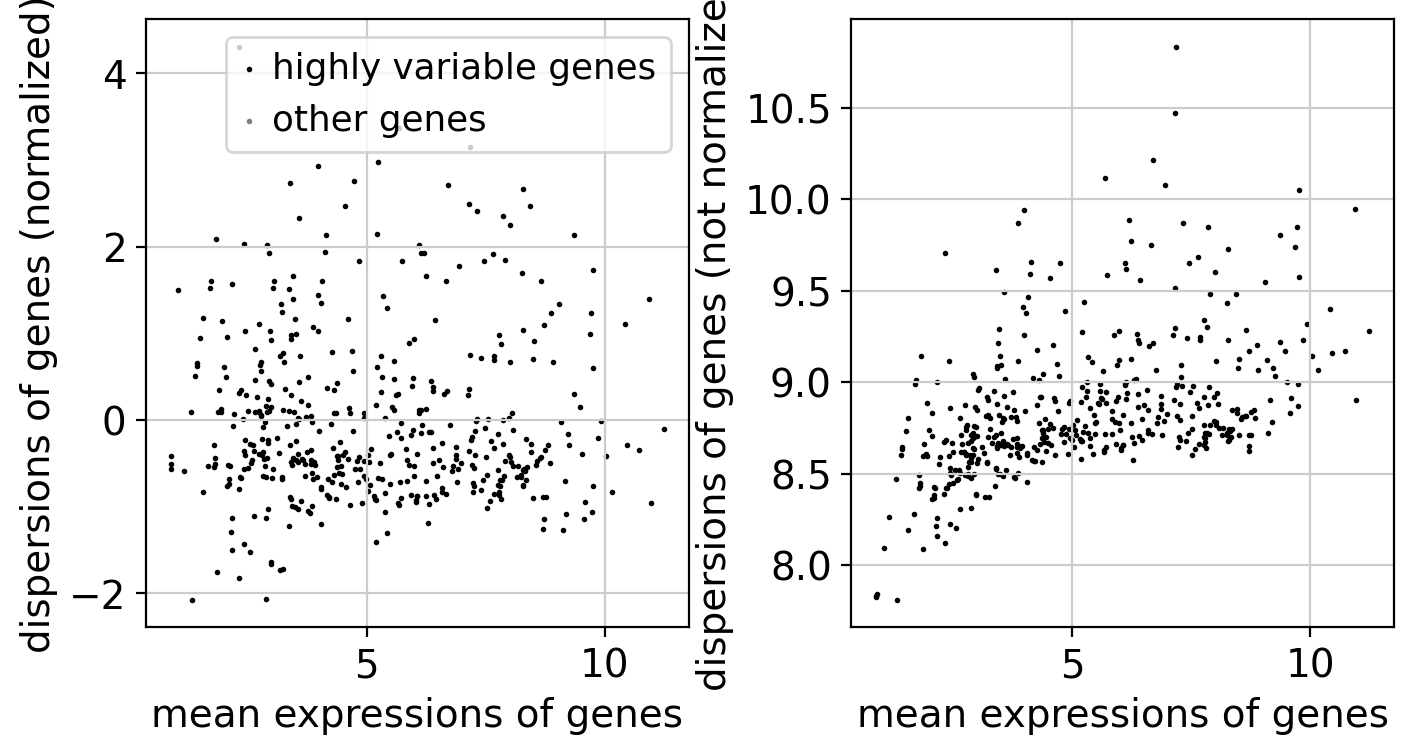

there are 480 hvgs


In [12]:
# compute PCA for the spatial dataset using HVGs
avis.uns['log1p']['base'] = np.e
sc.pp.highly_variable_genes(avis, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5, n_top_genes=avis.shape[1])
sc.pl.highly_variable_genes(avis)
# report how many HVGs we're going to use
print('there are', avis.var['highly_variable'].sum(), 'hvgs')

## learn with CCE for xenium

In [13]:
from scipy.spatial.distance import pdist, squareform
# create a gene subset for testing
genes = avis.var_names[avis.var['highly_variable']].tolist()
# retrieve positions from the data
pos = torch.from_numpy(df[['x_centroid','y_centroid']].values)
# convert the gene expression data to numpy
x = torch.from_numpy(avis[:, genes].X.todense())
# sphere normalize the data (just in case)
norm_factor = torch.pow(x, 2).sum(1).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# compute the distances
distances = squareform(pdist(df.loc[mask, ['x_centroid','y_centroid']]))
# compute the edges as two cell widths apart so 30µm
edge_index = torch.from_numpy(np.array(np.where((distances < 15)&(distances != 0))))

In [14]:
# define the parameters of the model
n_genes = len(genes)
learning_rate = 5e-2
zmft_scalar = 1e-1
seed = 0
epochs = 200

In [15]:
# instantiate the model, input and output will be the same
model_rev = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)

# now perform the simulation
np.random.seed(seed)
# artifically set the g2g matrix
input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)
model_rev.set_g2g(torch.from_numpy(input_g2g))
model_rev.set_g2g_intra(torch.from_numpy(input_g2g))
# initialize a gene expression matrix
model_rev.set_gex(x)

In [16]:
from tqdm import tqdm
# setup the initial optimizer
optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
# keep track of the losses per data object
loss, losses = None, []
# train the model
model_rev.train()
# work through epochs
for epoch in tqdm(range(epochs), total=epochs):
    # derive the message as well as the mean field approximation
    msg, msg_intra, log_z_mft = model_rev(edge_index, 1)
    # compute the loss and track it
    loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model_rev.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model_rev.gex))) )
    losses.append(loss.detach().numpy()[0][0])
    # derive the gradients, update, and clear
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # repeatedly force a normalization
    model_rev.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.conv1.lin.weight), requires_grad=True)
    model_rev.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.lin.weight), requires_grad=True)
    optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.10it/s]


[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

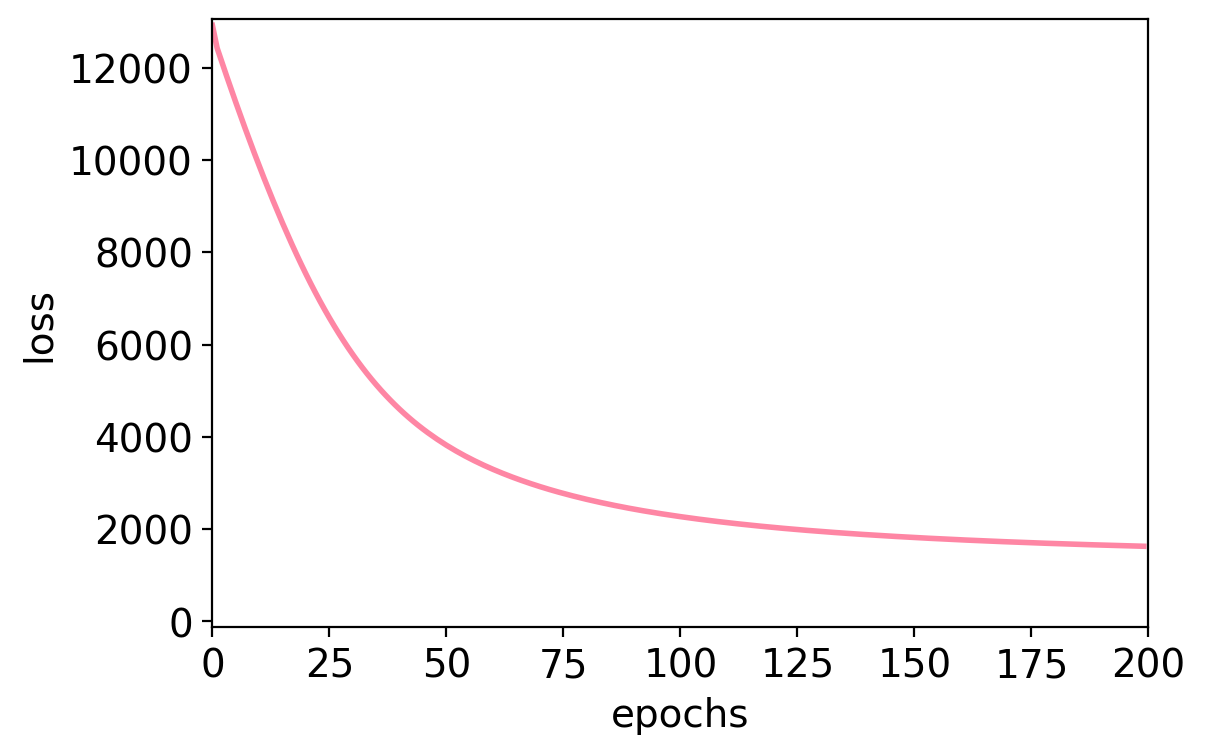

In [17]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

## perform disentanglement

In [ ]:
# retrieve the g2gs
g2g_intercellular = pd.DataFrame(model_rev.conv1.lin.weight.detach().numpy(), index=genes, columns=genes)
g2g_intracellular = pd.DataFrame(model_rev.lin.weight.detach().numpy(), index=genes, columns=genes)

In [ ]:
# define the gene
secs = pd.read_table('quickgo_secreted.tsv')['SYMBOL'].unique()
sps = pd.read_table('quickgo_surfaceprotein.tsv')['SYMBOL'].unique()
nons = pd.Index(genes)[(~pd.Index(genes).isin(secs))&(~pd.Index(genes).isin(sps))]
secs = pd.Index(genes).intersection(secs)
sps = pd.Index(genes).intersection(sps)

In [ ]:
# derive the values
diffs_secs = (g2g_intercellular.loc[secs, :] - g2g_intracellular.loc[secs, :]).values.flatten()
diffs_sps = (g2g_intercellular.loc[sps, :] - g2g_intracellular.loc[sps, :]).values.flatten()
diffs_nons = (g2g_intercellular.loc[nons, :] - g2g_intracellular.loc[nons, :]).values.flatten()
# assemble them
ys = np.hstack([diffs_secs, diffs_sps, diffs_nons])
ys -= ys.mean()
ys /= ys.std()
xs = np.array(['Secreted']*len(diffs_secs)+['Membrane']*len(diffs_sps)+['Cytoplasmic']*len(diffs_nons))
# create plot
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x=xs[::-1], y=ys[::-1], saturation=1, ci=95, errwidth=2, capsize=0.3, linewidth=2,
            errcolor='k', edgecolor='k', palette=['#cc78bc','#d55e00','#029e73'][::-1])
ax.set_xlim(-0.75, 2.75)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('Inter - intra G2G (Z-score)')
ax.spines[['right', 'top']].set_visible(False)
# derive pvalues
p1 = ss.mannwhitneyu(ys[xs == 'Secreted'], ys[xs == 'Membrane'])[1]
p2 = ss.mannwhitneyu(ys[xs == 'Secreted'], ys[xs == 'Cytoplasmic'])[1]
p3 = ss.mannwhitneyu(ys[xs == 'Cytoplasmic'], ys[xs == 'Membrane'])[1]
print(p1, p2, p3, sep='\n')

## perturb the GBM data

In [18]:
# define a function to derive the gex from the sphex
def calc_gex(sphex):
    """
    Calculates the gene expression matrix from the spherical
    """
    # setup the gex
    n_genes = sphex.shape[1]+1
    gex = torch.from_numpy(np.zeros((sphex.shape[0], n_genes)).astype('float32'))
    # compute the gex
    for idx in range(n_genes):
        if idx == n_genes-1:
            gex[:,idx] = torch.sin(sphex[:,idx-1])
        else:
            gex[:,idx] = torch.cos(sphex[:,idx])
        for idx_ in range(idx):
            gex[:,idx] *= torch.sin(sphex[:,idx_])
    return torch.nan_to_num(gex)

In [19]:
# define a function to derive the gex from the sphex
def calc_sphex(gex):
    """
    Calculates the spherical expression matrix from the normal
    """
    # setup the gex
    n_sgenes = gex.shape[1]-1
    sphex = torch.from_numpy(np.zeros((gex.shape[0], n_sgenes)).astype('float32'))
    # compute the gex
    for idx in range(n_sgenes):
        sphex[:,idx] = gex[:,idx]
        for idx_ in range(idx):
            sphex[:,idx] /= torch.sin(sphex[:,idx_])
        sphex[:,idx] = torch.arccos(sphex[:,idx])
    return sphex

In [20]:
# define the celcomen class
class simcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(simcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.sphex = None
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_sphex(self, sphex):
        """
        Artifically sets the current sphex matrix
        """
        self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the gex
        self.gex = calc_gex(self.sphex)
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

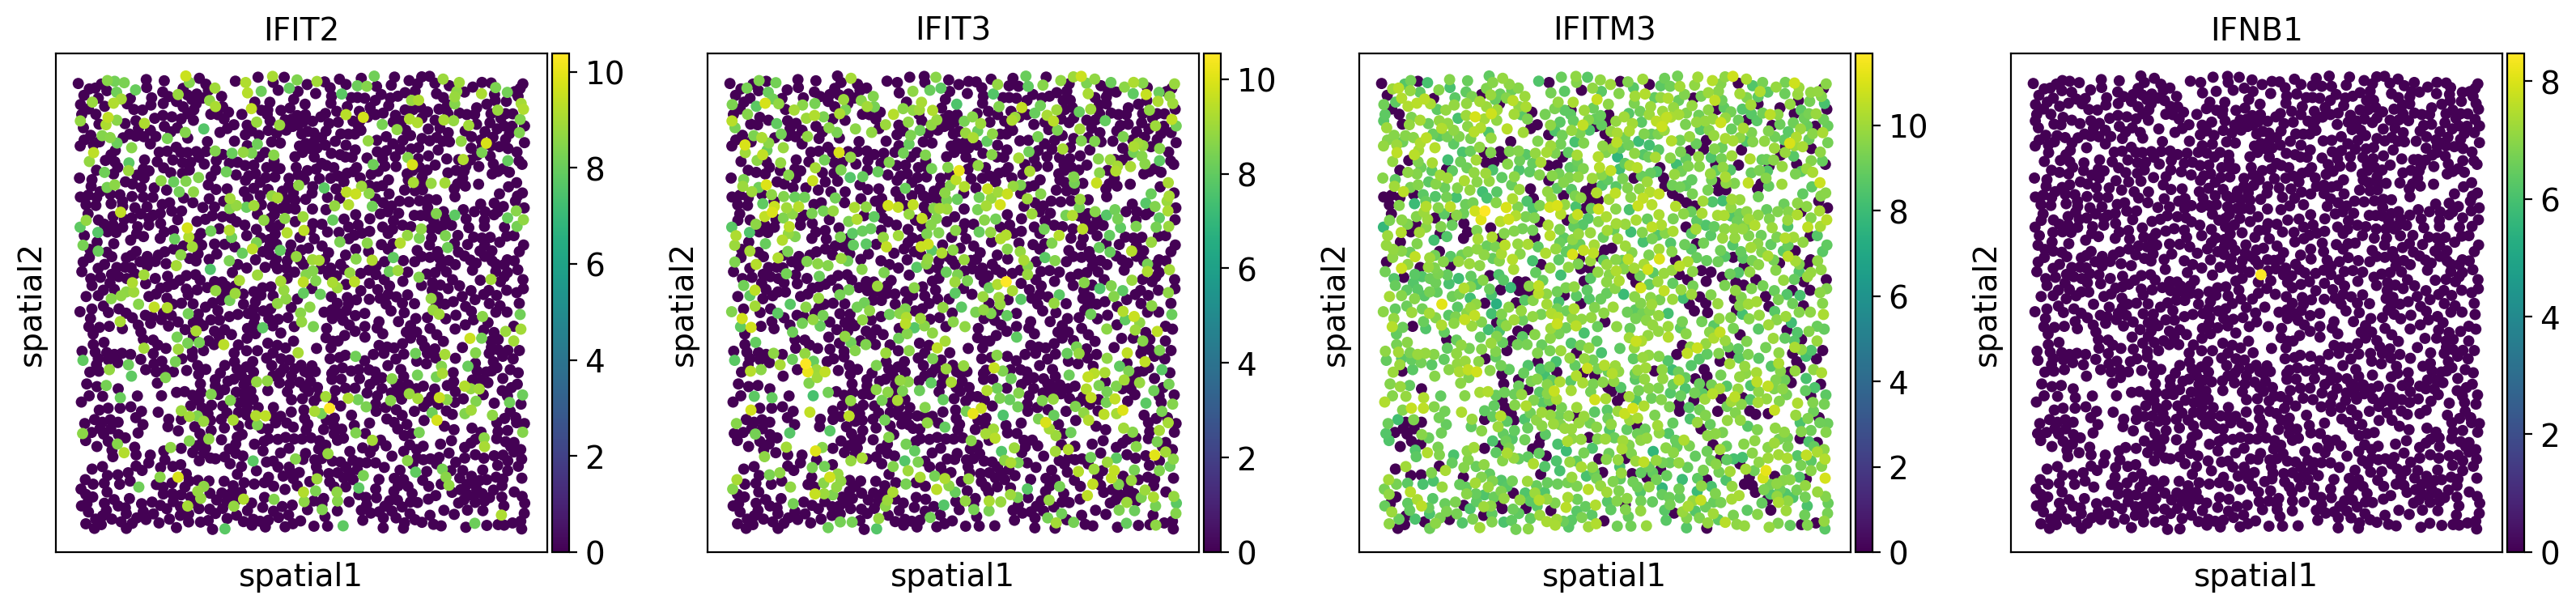

In [21]:
# find the genes
avis_sub = avis[:, avis.var['highly_variable']].copy()
sc.pl.embedding(avis_sub, basis='spatial', color=['IFIT2','IFIT3','IFITM3','IFNB1'], use_raw=False, s=1e2)

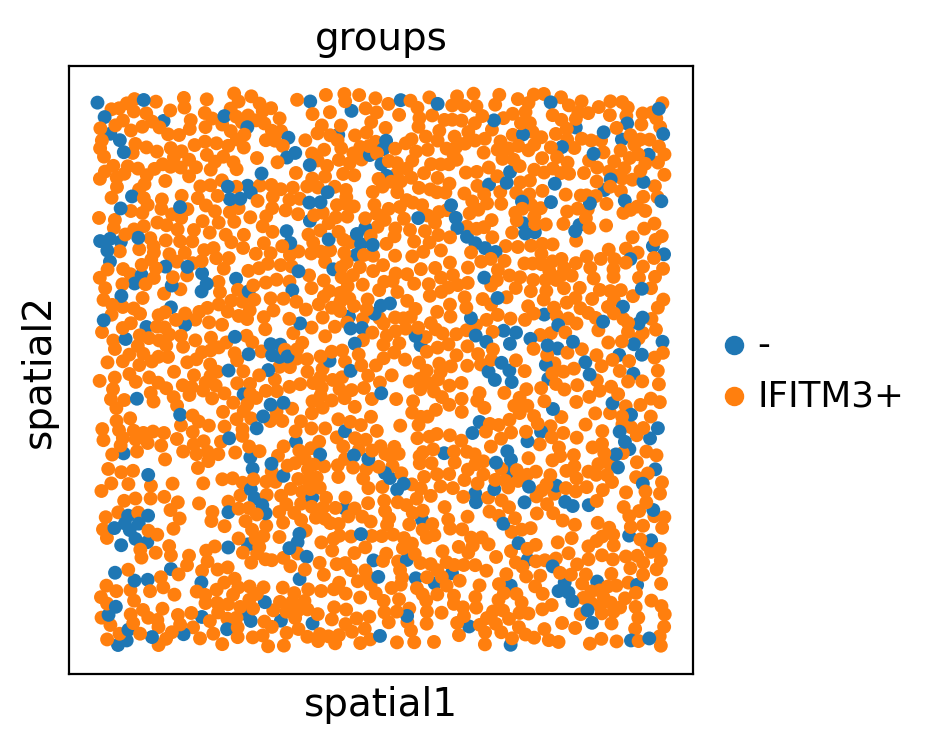

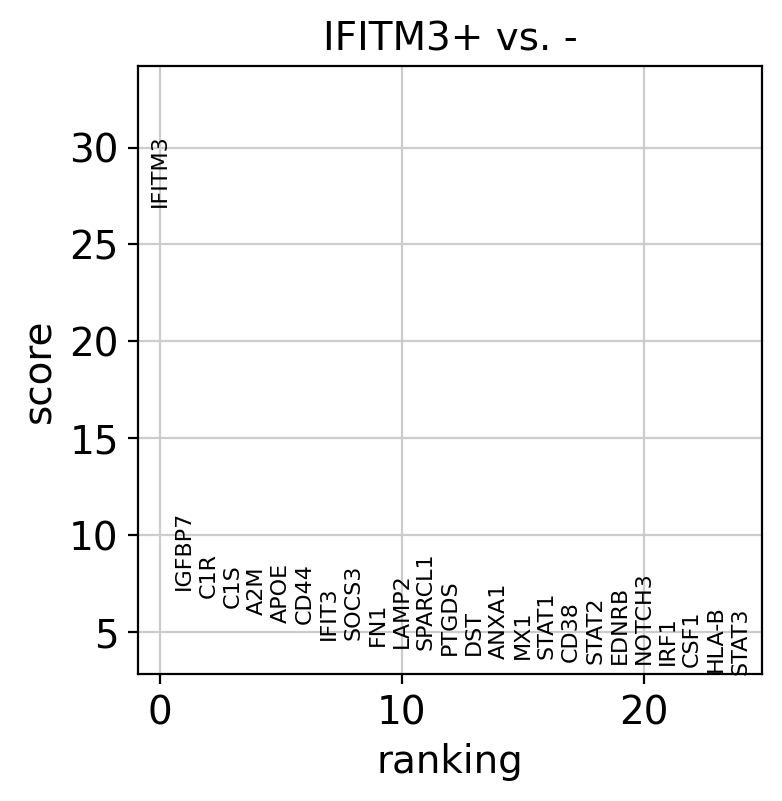

In [22]:
# define the genes that distinguish ISG15 spots currently
avis_sub.obs['groups'] = (sc.get.obs_df(avis_sub, keys=['IFITM3']).max(1) > 0).map({True:'IFITM3+', False:'-'})
sc.pl.embedding(avis_sub, basis='spatial', color=['groups'], use_raw=False, s=1e2)
# calculate differential expression
sc.tl.rank_genes_groups(avis_sub, method='wilcoxon', use_raw=False, groupby='groups', group=['IFITM3+'], reference='-')
sc.pl.rank_genes_groups(avis_sub, n_genes=25, sharey=False)

In [23]:
# derive the signature
'\''+'\',\''.join(pd.DataFrame(avis_sub.uns['rank_genes_groups']['names']).iloc[:25, 0].tolist())+'\''

"'IFITM3','IGFBP7','C1R','C1S','A2M','APOE','CD44','IFIT3','SOCS3','FN1','LAMP2','SPARCL1','PTGDS','DST','ANXA1','MX1','STAT1','CD38','STAT2','EDNRB','NOTCH3','IRF1','CSF1','HLA-B','STAT3'"

/tmp/ipykernel_28116/1489802821.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
/tmp/ipykernel_28116/1489802

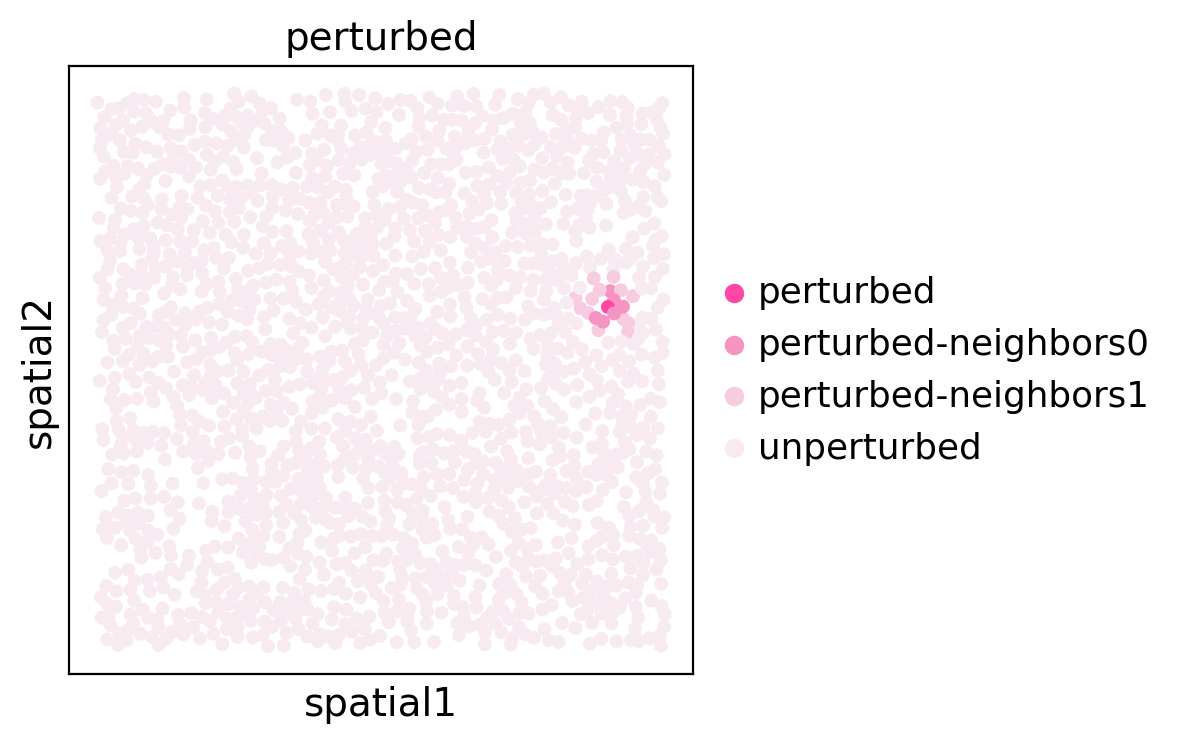

In [24]:
# propose an X introducing ISG15 inflammation
proposed_x = avis_sub.X.toarray().copy()
# adjust the X so we artificially introduce signaling to the center left side of the tissue
np.random.seed(0)
df_gex = sc.get.obs_df(avis_sub, keys=['IFITM3'])['IFITM3']
mask = avis_sub.obs.index == np.random.choice(avis_sub.obs.index[df_gex > 0], size=1)[0]
idx = np.where(avis_sub.var_names == 'IFITM3')[0][0]
proposed_x[mask, idx] = 0
avis_sub.obs['perturbed'] = 'unperturbed'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 15)[1]] = 'perturbed-neighbors0'
avis_sub.obs.loc[mask, 'perturbed'] = 'perturbed'
avis_sub.uns['perturbed_colors'] = ['#ff47a6','#f593c2','#f7cbe0','#f7ebf1']
sc.pl.embedding(avis_sub, basis='spatial', color=['perturbed'], use_raw=False, s=1e2)

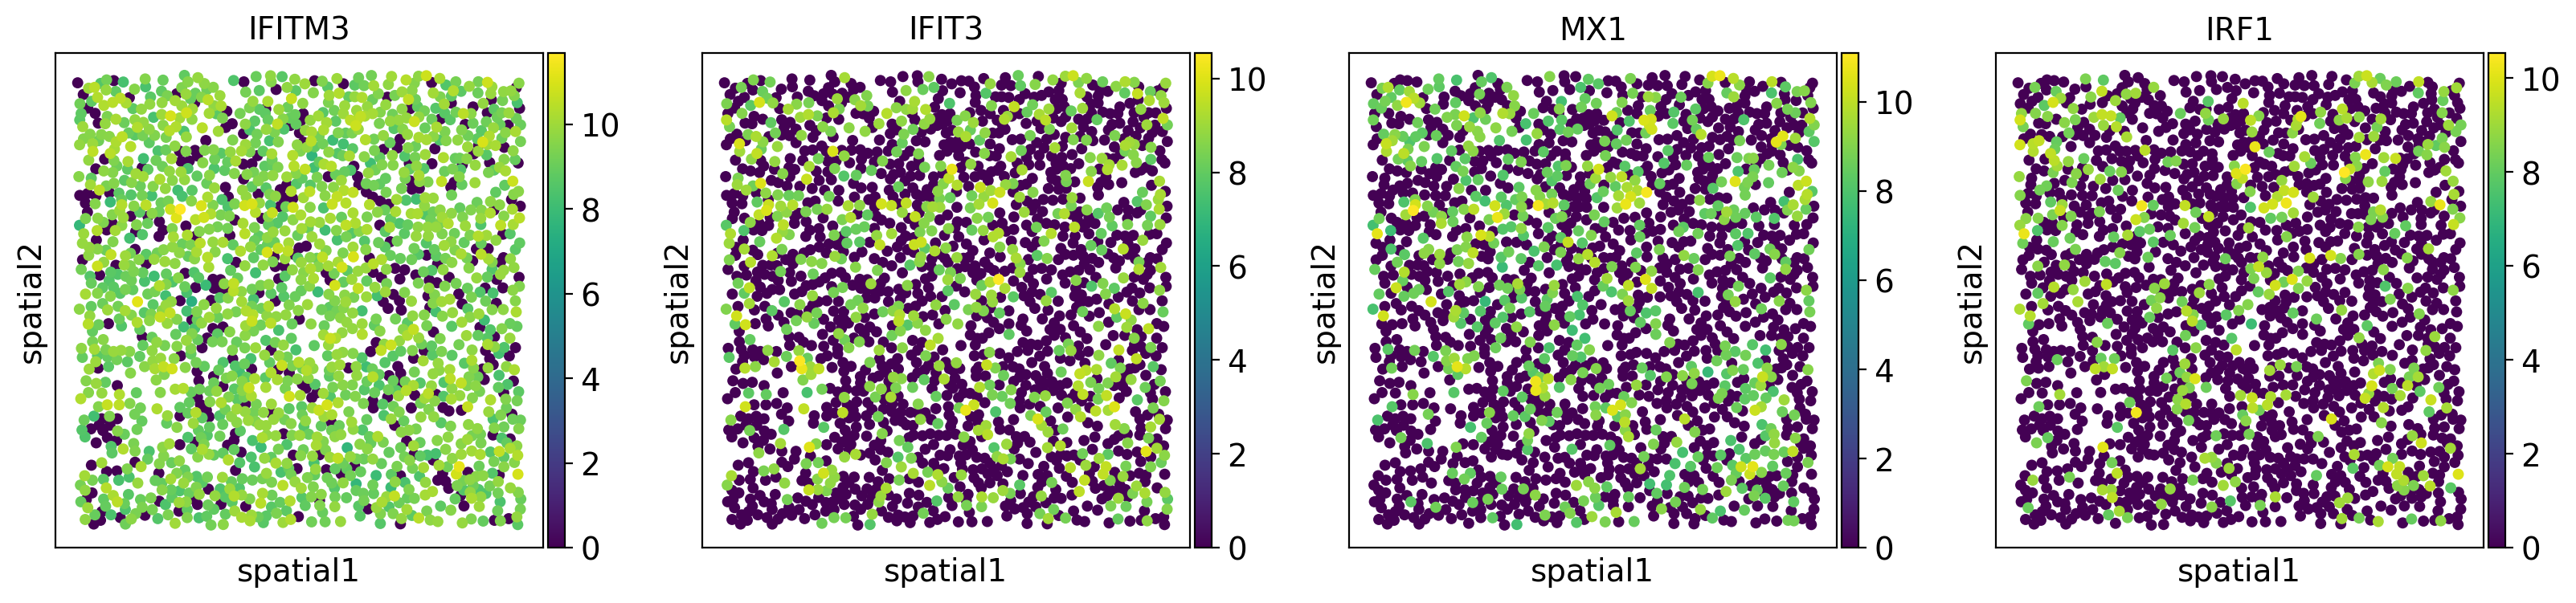

In [25]:
# demonstrate what the proposed x looks like pre scaling
avis_sub.X = proposed_x
sc.pl.embedding(avis_sub, basis='spatial', color=['IFITM3','IFIT3','MX1','IRF1'], use_raw=False, s=1e2)

In [28]:
# define the parameters of the model
n_genes = avis_sub.shape[1]
learning_rate = 1e-3
zmft_scalar = 1e-1
seed = 0
epochs = 10

In [29]:
# instantiate the model, input and output will be the same
model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
# now perform the simulation
np.random.seed(seed)
# convert the gene expression data to numpy
x = torch.from_numpy(proposed_x)
# sphere normalize the data (just in case)
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# artifically set the g2g matrix
model.set_g2g(model_rev.conv1.lin.weight.clone().detach())
model.set_g2g_intra(model_rev.lin.weight.clone().detach())
# initialize a gene expression matrix
input_sphex = calc_sphex(x).clone().detach().numpy()
model.set_sphex(torch.from_numpy(input_sphex.astype('float32')))

In [ ]:
# set up the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
# keep track of the losses per data object
loss, losses = None, []
# train the model
model.train()
tmp_gexs = []
# work through epochs
for epoch in tqdm(range(epochs), total=epochs):
    # derive the message as well as the mean field approximation
    msg, msg_intra, log_z_mft = model(edge_index, 1)
    if (epoch % 5) == 0:
        tmp_gex = model.gex.clone().detach().numpy()
        tmp_gexs.append(tmp_gex)
    # compute the loss and track it
    loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
    print(f"model.gex={model.gex}")
    print(f"log_z_mft={log_z_mft}")
    print(f"torch.trace(torch.mm(msg, torch.t(model.gex)))={torch.trace(torch.mm(msg, torch.t(model.gex)))}")
    print(f"torch.trace(torch.mm(msg_intra, torch.t(model.gex)))={torch.trace(torch.mm(msg_intra, torch.t(model.gex)))}")
    losses.append(loss.detach().numpy()[0][0])
    # derive the gradients, update, and clear
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

model.gex=tensor([[ 8.6101e-02, -4.3549e-08, -4.3549e-08,  ..., -4.1140e-09,
          0.0000e+00,  0.0000e+00],
        [ 1.2233e-01, -4.3383e-08, -4.3383e-08,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 9.4219e-02, -4.3517e-08, -4.3517e-08,  ..., -4.6848e-09,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.4471e-01, -4.3251e-08, -4.3251e-08,  ..., -5.6258e-09,
          0.0000e+00,  0.0000e+00],
        [-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -6.8656e-12,
         -6.8656e-12,  1.5707e-04],
        [ 1.3482e-01, -4.3312e-08, -4.3312e-08,  ..., -4.5348e-09,
          1.0374e-01,  7.7913e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[139673.4531]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=1628.483642578125
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=12238.8671875


 10%|███████████████▋                                                                                                                                             | 1/10 [02:42<24:18, 162.07s/it]

model.gex=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.4410e-04, -5.9992e-02, -5.7137e-02,  ...,  5.9815e-09,
          7.4339e-10, -6.6576e-04],
        [ 1.4609e-01, -5.8662e-02, -5.5910e-02,  ..., -4.3770e-04,
          7.4325e-02,  5.4465e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[317775.7812]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=7865.77685546875
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=20204.91015625


 20%|███████████████████████████████▍                                                                                                                             | 2/10 [05:30<22:04, 165.53s/it]

model.gex=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.1904e-03, -3.4199e-02, -3.2424e-02,  ...,  6.6893e-09,
          8.8552e-10, -1.5358e-04],
        [ 2.1724e-01, -3.2829e-02, -3.1202e-02,  ..., -1.5486e-04,
          7.6186e-02,  5.6710e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[112420.2188]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=1276.755615234375
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=3171.539794921875


 30%|███████████████████████████████████████████████                                                                                                              | 3/10 [08:28<19:59, 171.37s/it]

model.gex=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.5209e-03,  2.0552e-02,  1.9939e-02,  ..., -2.0284e-08,
         -2.6823e-09,  3.8551e-04],
        [ 2.5791e-01,  2.0010e-02,  1.9294e-02,  ...,  1.5747e-04,
          6.4622e-02,  4.8984e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[160855.2969]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=1533.7613525390625
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=10975.212890625


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 4/10 [12:07<19:02, 190.41s/it]

model.gex=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.4580e-03, -3.4375e-02, -3.2401e-02,  ...,  2.8950e-09,
          3.7145e-10, -3.8772e-05],
        [ 3.2967e-01, -2.9820e-02, -2.8223e-02,  ..., -6.5044e-05,
          5.2296e-02,  3.9040e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[52793.5664]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=482.5477294921875
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=1930.446044921875


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 5/10 [15:06<15:30, 186.09s/it]

model.gex=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.9196e-03,  2.3900e-02,  2.3278e-02,  ..., -1.8062e-08,
         -2.3332e-09,  2.3478e-04],
        [ 3.5556e-01,  2.3502e-02,  2.2693e-02,  ...,  8.4346e-05,
          4.5505e-02,  3.4403e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[117450.6953]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=855.2003784179688
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=7071.13232421875


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 6/10 [18:01<12:09, 182.44s/it]

model.gex=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.2119e-03, -3.2691e-02, -3.0679e-02,  ..., -3.7096e-10,
         -4.7503e-11,  4.0926e-06],
        [ 4.3071e-01, -2.4373e-02, -2.2991e-02,  ..., -2.8306e-05,
          3.5603e-02,  2.6623e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[20323.6895]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=239.58688354492188
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=1620.44677734375


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7/10 [20:57<09:00, 180.25s/it]

model.gex=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 8.1488e-03,  2.3922e-02,  2.3240e-02,  ..., -1.2227e-08,
         -1.5698e-09,  1.3525e-04],
        [ 4.3933e-01,  2.2928e-02,  2.2047e-02,  ...,  3.8944e-05,
          3.3231e-02,  2.5052e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[76563.2500]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=431.0067443847656
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=4266.6826171875


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8/10 [23:48<05:54, 177.23s/it]

model.gex=tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 8.3666e-03, -3.5116e-02, -3.3134e-02,  ..., -5.7739e-10,
         -7.4410e-11,  5.8683e-06],
        [ 5.0218e-01, -2.3318e-02, -2.2141e-02,  ..., -2.0851e-05,
          2.6372e-02,  1.9721e-07]], grad_fn=<NanToNumBackward0>)
log_z_mft=tensor([[14473.0186]], grad_fn=<AddBackward0>)
torch.trace(torch.mm(msg, torch.t(model.gex)))=207.59922790527344
torch.trace(torch.mm(msg_intra, torch.t(model.gex)))=1420.9156494140625


In [ ]:
# plot the loss
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
# retrieve the data
output_gex = model.gex.detach().numpy()
output_msg = msg.detach().numpy()

In [ ]:
# find the genes of interest
genes = ['IFITM3','IFIT3','MX1','IRF1']
genes = [x for x in genes if x in avis_sub.var_names.tolist()]

In [ ]:
# add the layers
for idx, tmp_gex in enumerate(tmp_gexs):
    avis_sub.layers[f'input{idx}'] = tmp_gex
avis_sub.layers['output'] = output_gex

In [ ]:
# plot the genes of interest
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input0')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input3')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='output')

In [ ]:
# compute the differential within the area of interest vs outside
avis_sub.layers['diff'] = avis_sub.layers['output'] - avis_sub.layers['input0']
mask0 = avis_sub.obs['perturbed'] == 'unperturbed'
mask1 = avis_sub.obs['perturbed'] == 'perturbed'
diff_in_vs_out_p = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# now compute differential for neighbors
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
diff_in_vs_out_pn0 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
diff_in_vs_out_pn1 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# remove the perturbed genes to get a clean look
perturbed_genes = ['IFITM3']
perturbed_label = 'ifitm3'
diff_in_vs_out_p = diff_in_vs_out_p.loc[~diff_in_vs_out_p.index.isin(perturbed_genes)]
diff_in_vs_out_pn0 = diff_in_vs_out_pn0.loc[~diff_in_vs_out_pn0.index.isin(perturbed_genes)]
diff_in_vs_out_pn1 = diff_in_vs_out_pn1.loc[~diff_in_vs_out_pn1.index.isin(perturbed_genes)]
# write these matrices out
diff_in_vs_out_p.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_p.csv')
diff_in_vs_out_pn0.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn0.csv')
diff_in_vs_out_pn1.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn1.csv')

In [ ]:
# do not include isg15 itself
genes_ = pd.DataFrame(avis_sub.uns['rank_genes_groups']['names']).iloc[:25, 0].tolist()[1:]

In [ ]:
# retrieve the results
df_expr = pd.DataFrame(columns=['p','pn0','pn1','u'])
for layer in ['input1','input2','input3','input4','input5','input6','input7','input8','input9','output']:
    # compute the expression
    mask1 = avis_sub.obs['perturbed'] == 'perturbed'
    expr_p = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
    expr_pn0 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
    expr_pn1 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'unperturbed'
    expr_u = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    df_expr.loc[layer] = expr_p, expr_pn0, expr_pn1, expr_u

In [ ]:
# derive the scores
fig, ax = plt.subplots(figsize=[2.9, 5.6])
ax = sns.heatmap(df_expr, cmap='viridis')
ax.grid(False)

In [ ]:
# derive the scores
df_expr -= np.mean(df_expr.values.flatten())
df_expr /= np.std(df_expr.values.flatten())
fig, ax = plt.subplots(figsize=[2.9, 5.6])
ax = sns.heatmap(df_expr, cmap='viridis')
ax.grid(False)

In [ ]:
# derive the scores
for col, color in zip(['p','pn0','pn1','u'], ['#ff47a6','#f593c2','#f7cbe0','#f7ebf1']):
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.scatter(df_expr.index, df_expr[col], color='k', s=9e1, zorder=1)
    ax.scatter(df_expr.index, df_expr[col], color=color, s=5e1, zorder=2)
    ax.plot(df_expr.index, df_expr[col], color='k', lw=3.5, zorder=0)
    ax.plot(df_expr.index, df_expr[col], color=color, lw=1, zorder=2)
    ax.grid(False)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set(xlabel='timepoint', ylabel='IFITM3 score', title=col)

In [ ]:
# # run the following in R
# # load gene sets
# # > import package
# library(msigdbr)
# print(paste0('MSigDb Version: ', packageVersion("msigdbr")))
# # > gather gene sets
# categories <- c("H", "C2", "C5", "C6", "C7")
# gene_sets <- c()  # instantiate list of all gene sets
# msigdbr_t2gs <- c()
# for (category in categories) {
#   msigdbr_df <- msigdbr(species = "Homo sapiens", category = category)
#   msigdbr_list <- split(x = msigdbr_df$gene_symbol, f = msigdbr_df$gs_name)
#   gene_sets <- c(gene_sets, msigdbr_list)
#   msigdbr_t2g <- msigdbr_df %>% dplyr::distinct(gs_name, gene_symbol) %>% as.data.frame()
#   msigdbr_t2gs <- rbind(msigdbr_t2gs, msigdbr_t2g)
# }
# 
# # retrieve the gsea object
# library(GSEABase)
# library(clusterProfiler)
# library(DOSE)
# library(org.Mm.eg.db)
# library(ggplot2)
# library(stringr)
# 
# # add on our custom signature
# genes <- c('IGFBP7','C1R','C1S','A2M','APOE','CD44','IFIT3','SOCS3','FN1','LAMP2','SPARCL1','PTGDS','DST','ANXA1','MX1','STAT1','CD38','STAT2','EDNRB','NOTCH3','IRF1','CSF1','HLA-B','STAT3')
# tmp <- data.frame(gs_name='DC20_CUSTOM_IFITM3_SIGNATURE', gene_symbol=genes)
# msigdbr_t2gs_tmp <- rbind(msigdbr_t2gs, tmp)
# 
# # define the filename
# for (comp in c("diff_in_vs_out_p", "diff_in_vs_out_pn0", "diff_in_vs_out_pn1")) {
#   fn <- paste0("20240618.learn_then_perturb.xenium_gbm.ifitm3.", comp, ".csv")
#   # read in the rankings
#   rankedGenes <- read.csv(fn, row.names=1)
#   # rename and shape the rankings
#   geneNames <- rownames(rankedGenes)
#   geneList <- rankedGenes$X0
#   names(geneList) <- geneNames
#   geneList <- sort(geneList, decreasing=T)
#   # create signatures
#   egmt <- GSEA(geneList, TERM2GENE=msigdbr_t2gs, verbose=F, pvalueCutoff=1,
#                minGSSize=15, maxGSSize=500)
#   # save the data
#   data <- data.frame(egmt)[c("enrichmentScore","NES","pvalue","p.adjust","qvalues","setSize")]
#   out_fn <- paste0("20240618.learn_then_perturb.xenium_gbm.ifitm3.", comp, ".gsea.csv")
#   write.csv(data, file=out_fn)
# }